------

### Requirements
```python
# numpy==1.23.4
# matplotlib
torch
# scikit-image
# odl==0.7.0
# dival
# wget # for downloading the test data
pillow # Image utils
```

In [1]:
# !pip install pillow
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm

In [30]:
import os

import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.data import Dataset

from functools import partial

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

# Optional
from tqdm import tqdm # progress bar


In [3]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Path: {os.getcwd()}")

/mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv/bin/python
Torch version: 2.2.2+cu121
Path: /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/scripts/dyn_img_static


In [39]:
DISABLING_TESTS = False
# DISABLING_TESTS = True   # Disable tests for less output

### Use GPU

In [88]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

Using NVIDIA GeForce RTX 4090


------

### Import the image

Read the image

Visualise one example

In [4]:
# OPTIONAL CODE TO DOWNLOAD THE DATA

#### Take a single image

In [ ]:
def get_npy_file(sample_path: str, scale_factor: float) -> np.ndarray:			
    scale_factor_str = str(scale_factor).replace('.','_')
    xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
    
    xf = torch.tensor(xf, dtype=torch.float)
    # xf = xf.unsqueeze(0)	# Is it necessary???
    xf = xf.unsqueeze(0) / 255

    return xf

In [52]:
# CODE TO GET AN IMAGE FROM LOCAL FILE SYSTEM
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images(ids: list, take_npy_files: bool) -> list:
    data_path = "../../data/dyn_img_static/tmp/SIDD_Small_sRGB_Only/Data"
    k = 0

    images = []

    for folder in os.listdir(data_path):
        img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
        if img_id not in ids:
            continue
        k += 1
        print(f'loading image id {img_id}, {k}/{len(ids)}')

        files_path = os.path.join(data_path, folder)

        # if take_npy_files:
        #     xf = get_npy_file(files_path, scale_factor)
        #     images.append(xf)
        #     continue

        # Use only the ground truth images
        file = "GT_SRGB_010.PNG"  # GT = Ground Truth

        image = Image.open(os.path.join(files_path, file))
        assert image.mode == 'RGB', f"Image mode is not RGB: {image.mode}" # For now, expect RGB images
        # width, height = image.size
        # Width and height are NOT always the same
        # assert (width, height) == (5328, 3000), f"Image size is not 5328x3000: {image.size}" # For now, expect 5328x3000 images



        # #resize
        # Nx_,Ny_ = np.int(np.floor(scale_factor * image.width )), np.int(np.floor(scale_factor * image.height ))
        # image = image.resize( (Nx_, Ny_) )
        
        # #convert to grey_scale
        # image = image.convert('L')
        # image_data = np.asarray(image)
        # images.append(image_data)
        images.append(image)

    return images

loading image id 0065, 1/1
(4048, 3044)


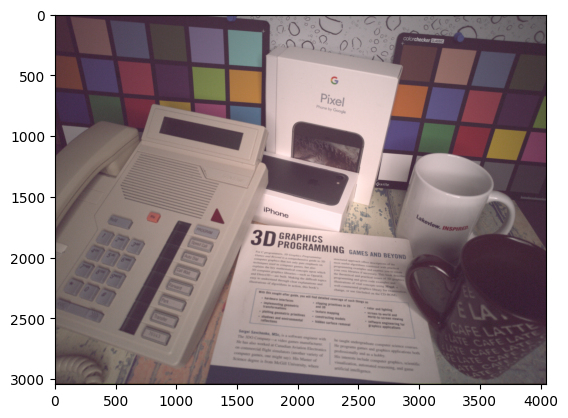

In [53]:
def test_load_images():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        print(img.size)
        plt.imshow(img)

test_load_images()

------

#### Convert image to grayscale

In [37]:
# CODE TO CONVERT AN IMAGE TO GRAYSCALE
def convert_to_grayscale(image: Image) -> Image:
    return image.convert('L')

loading image id 0065, 1/1


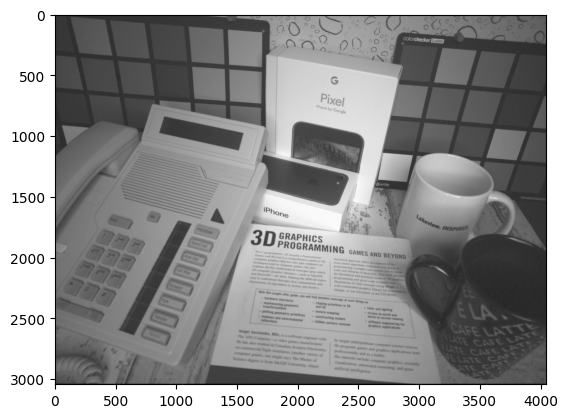

In [57]:
def test_convert_to_grayscale():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_convert_to_grayscale()

#### Resize image

(Optional) Rescale the image

Make the image a bit smaller

Example:

Original 5328 x 3000

Recaled 0.5 to 2664 x 1500

In [46]:
def resize_image(image, scale_factor):
    Nx_,Ny_ = np.int(np.floor(scale_factor * image.width )), np.int(np.floor(scale_factor * image.height ))
    image = image.resize( (Nx_, Ny_) )
    return image

loading image id 0065, 1/1
(202, 152)


/tmp/ipykernel_9071/827609784.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Nx_,Ny_ = np.int(np.floor(scale_factor * image.width )), np.int(np.floor(scale_factor * image.height ))


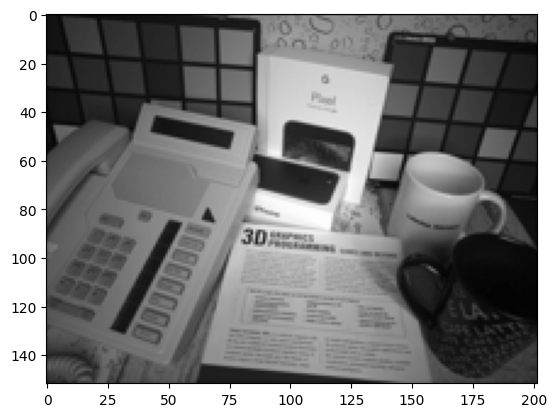

In [66]:
def test_resize_image():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        img = resize_image(img, 0.05) # Extreme size reduction for demonstration
        print(img.size)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_resize_image()

#### Convert to and revert from numpy array

In [60]:
def convert_to_numpy(image):
    image_data = np.asarray(image)
    return image_data

loading image id 0065, 1/1
Before conversion: <class 'PIL.Image.Image'>
After conversion: <class 'numpy.ndarray'>


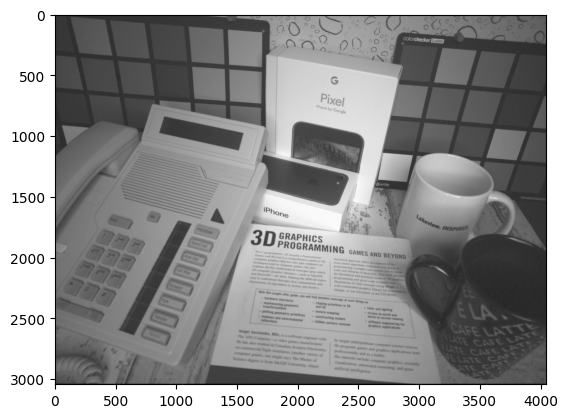

In [65]:
def test_convert_to_numpy():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        print(f"Before conversion: {type(img)}")
        image_data = convert_to_numpy(img)
        print(f"After conversion: {type(image_data)}")
        # plt.imshow still works with numpy array
        plt.imshow(image_data, cmap='gray')

test_convert_to_numpy()

#### Convert to tensor

For efficient computation on GPU

In [74]:
def convert_to_tensor(image_data, device):
    image_data = torch.tensor(image_data, dtype=torch.float, device=device)
    image_data = image_data.unsqueeze(0) / 255
    return image_data

loading image id 0065, 1/1
torch.Size([1, 3044, 4048])


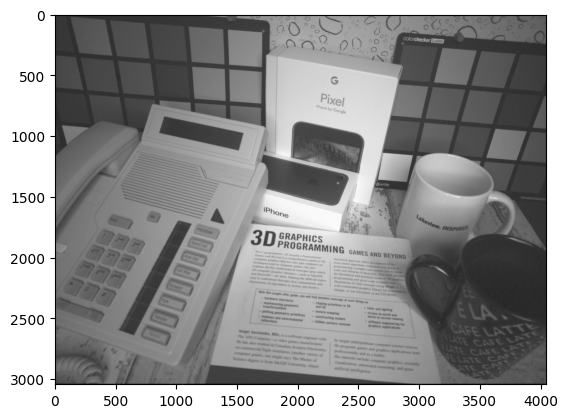

In [77]:
def test_convert_to_tensor():
    if DISABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        image_data = convert_to_numpy(img)
        image_data = convert_to_tensor(image_data, torch.device('cpu')) # Store on CPU for visualisation
        print(image_data.size())
        plt.imshow(image_data.squeeze(0), cmap='gray')

test_convert_to_tensor()

------

### Add synthetic noise

artificial Gaussian noise

Noise can occur in reality.

It is difficult to obtain a pair of clean and noisy images of one exact same scene.

For training, it is common to add synthetic noise to an image that is considered clean and then try to reconstruct it.

There are many types of noise and different ways to add noise. We can add salt-and-pepper noise. (?)We can add more noise in some parts and less in others. We can use a combination of noise-adding strategies to build more robust models.

For our purpose, we will focus on Gaussian noise. This is sufficient for most cases. 

(?) We will add noise with the same probability for each pixel (not using the strategies of focusing on certain regions)

In [78]:
# CODE TO ADD NOISE HERE
def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    # if noise_level == 'constant':
    #     sigma = self.sigma
        
    # elif self.noise_level == 'variable':
    #     sigma = self.sigma_min + torch.rand(1) * ( self.sigma_max - self.sigma_min )

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    # return (xnoise.to(device), xf.to(device))
    return xnoise

loading image id 0001, 1/1


/tmp/ipykernel_9071/827609784.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Nx_,Ny_ = np.int(np.floor(scale_factor * image.width )), np.int(np.floor(scale_factor * image.height ))


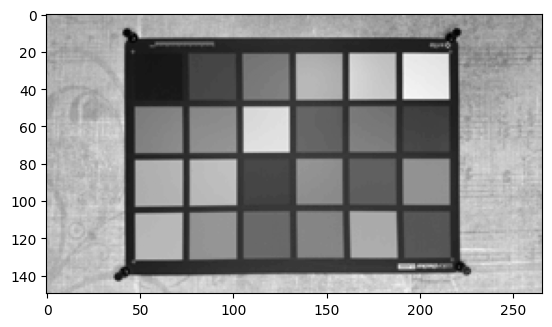

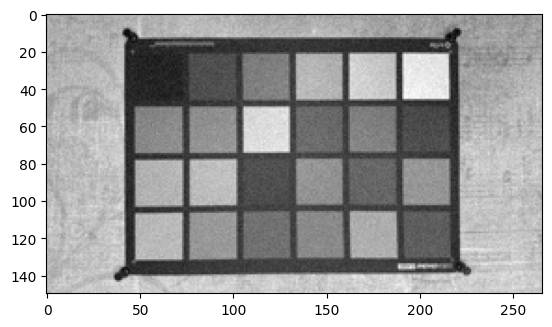

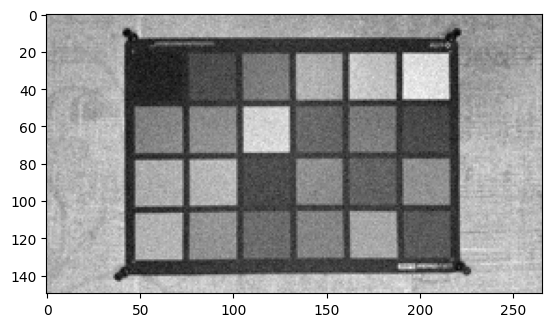

In [86]:
def test_add_noise():
    if DISABLING_TESTS: return
    for rgb_image in load_images(["0001"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.05)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data, torch.device('cpu'))
        constant_noise_img = add_noise(image_data, sigma=0.1)
        variable_noise_img = add_noise(image_data, get_variable_noise(
            sigma_min=0.1, sigma_max=0.2))
        plt.imshow(image_data.squeeze(0), cmap='gray')
        plt.show();
        plt.imshow(constant_noise_img.squeeze(0), cmap='gray')
        plt.show();
        plt.imshow(variable_noise_img.squeeze(0), cmap='gray')
        plt.show();
test_add_noise()

------

### Calculate PSNR

PSNR is a common metrics for noisy image.

Compare before and after adding synthetic noise

In [10]:
# CODE TO CALCULATE THE PSNR HERE

------

### Divide image into patches

Cut into 192 x 192 small patches. Each patch is one input (right?)

??? Should I try to make the patch size divisible by the image dimension: 222 * 125

5328 = 222 * 24
3000 = 125 * 24

2664 = 222 * 12
3000 = 125 * 12

In [11]:
# CODE TO DIVIDE THE IMAGE INTO PATCHES HERE

def extract_patches_3d(x, kernel_size, padding=0, stride=1, dilation=1):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size, kernel_size)
    if isinstance(padding, int):
        padding = (padding, padding, padding)
    if isinstance(stride, int):
        stride = (stride, stride, stride)
    if isinstance(dilation, int):
        dilation = (dilation, dilation, dilation)

    # print(f"x.shape: {x.shape}")
    # print(f"kernel_size: {kernel_size}")
    # print(f"padding: {padding}")
    # print(f"stride: {stride}")
    # print(f"dilation: {dilation}")
    # x.shape: torch.Size([1, 1, 540, 960, 600])
    # kernel_size: [192, 192, 32]
    # padding: (0, 0, 0)
    # stride: [192, 192, 16]
    # dilation: (1, 1, 1)

    def get_dim_blocks(dim_in, dim_kernel_size, dim_padding = 0, dim_stride = 1, dim_dilation = 1):
        dim_out = (dim_in + 2 * dim_padding - dim_dilation * (dim_kernel_size - 1) - 1) // dim_stride + 1
        return dim_out

    channels = x.shape[-4]
    d_dim_in = x.shape[-3]
    h_dim_in = x.shape[-2]
    w_dim_in = x.shape[-1]
    d_dim_out = get_dim_blocks(d_dim_in, kernel_size[0], padding[0], stride[0], dilation[0])
    h_dim_out = get_dim_blocks(h_dim_in, kernel_size[1], padding[1], stride[1], dilation[1])
    w_dim_out = get_dim_blocks(w_dim_in, kernel_size[2], padding[2], stride[2], dilation[2])
    # print(d_dim_in, h_dim_in, w_dim_in, d_dim_out, h_dim_out, w_dim_out)
    # print(f"d_dim_in = {d_dim_in}")
    # print(f"h_dim_in = {h_dim_in}")
    # print(f"w_dim_in = {w_dim_in}")
    # print(f"d_dim_out = {d_dim_out}")
    # print(f"h_dim_out = {h_dim_out}")
    # print(f"w_dim_out = {w_dim_out}")
    # d_dim_in = 540
    # h_dim_in = 960
    # w_dim_in = 600
    # d_dim_out = 2
    # h_dim_out = 5
    # w_dim_out = 36

    # (B, C, D, H, W)
    x = x.view(-1, 
               channels, 
               d_dim_in, 
               h_dim_in * w_dim_in)                                                     
    # (B, C, D, H * W)

    x = torch.nn.functional.unfold(x, 
                                   kernel_size=(kernel_size[0], 1), 
                                   padding=(padding[0], 0), 
                                   stride=(stride[0], 1), 
                                   dilation=(dilation[0], 1))                   
    # (B, C * kernel_size[0], d_dim_out * H * W)

    # print(f"x.shape: {x.shape}")
    # x.shape: torch.Size([1, 192, 1152000])
    # 1 * 192 * 1,152,000 = 221,184,000
    # print(f"channels = {channels}")
    # print(f"kernel_size[0] = {kernel_size[0]}")
    # print(f"d_dim_out = {d_dim_out}")
    # print(f"h_dim_in = {h_dim_in}")
    # print(f"w_dim_in = {w_dim_in}")
    # print(f"channels * kernel_size[0] * d_dim_out * h_dim_out * w_dim_out: {channels * kernel_size[0] * d_dim_out * h_dim_out * w_dim_out}")
    # extracting patches of shape [192, 192, 32]; strides [192, 192, 16]
    # x.shape: torch.Size([1, 192, 1152000])
    # channels = 1
    # kernel_size[0] = 192
    # d_dim_out = 2
    # h_dim_in = 960
    # w_dim_in = 600
    # channels * kernel_size[0] * d_dim_out * h_dim_out * w_dim_out: 69120

    x = x.view(-1, 
               channels * kernel_size[0] * d_dim_out, 
               h_dim_in, 
               w_dim_in)                                   
    # (B, C * kernel_size[0] * d_dim_out, H, W)

    x = torch.nn.functional.unfold(x, 
                                   kernel_size=(kernel_size[1], kernel_size[2]), 
                                   padding=(padding[1], padding[2]), 
                                   stride=(stride[1], stride[2]), 
                                   dilation=(dilation[1], dilation[2]))        
    # (B, C * kernel_size[0] * d_dim_out * kernel_size[1] * kernel_size[2], h_dim_out, w_dim_out)

    x = x.view(-1, channels, kernel_size[0], d_dim_out, kernel_size[1], kernel_size[2], h_dim_out, w_dim_out)  
    # (B, C, kernel_size[0], d_dim_out, kernel_size[1], kernel_size[2], h_dim_out, w_dim_out)  

    x = x.permute(0, 1, 3, 6, 7, 2, 4, 5)
    # (B, C, d_dim_out, h_dim_out, w_dim_out, kernel_size[0], kernel_size[1], kernel_size[2])

    x = x.contiguous().view(-1, channels, kernel_size[0], kernel_size[1], kernel_size[2])
    # (B * d_dim_out * h_dim_out * w_dim_out, C, kernel_size[0], kernel_size[1], kernel_size[2])

    return x

------

### Stitch the patches together

Prep for inference

In [12]:
# CODE TO COMBINE THE PATCHES BACK INTO AN IMAGE HERE

------

### Data loading class

In [13]:
class DynamicImageStaticDenoisingDataset(Dataset):
	
	def __init__(
		self, 
		data_path: str, 
		ids: list,
		scale_factor = 0.5, 
		sigma=0.23,  
		patches_size = None,
		strides= None,
		extract_data=True,
		device: str = "cuda"
	):
		self.device = device
		self.scale_factor = scale_factor

		ids = [str(x).zfill(2) for x in ids]

		xf_list = []
  
		k = 0
		# for k, img_id in enumerate(ids):
		for folder in os.listdir(data_path):
			img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
			if img_id not in ids:
				continue
			k += 1
			print(f'loading image id {img_id}, {k}/{len(ids)}')
			# sample_path = os.path.join(data_path, f"MOT17-{img_id}")
			sample_path = os.path.join(data_path, folder)
			if extract_data:
				xf = self.create_dyn_img(sample_path)
				# xf = xf.unsqueeze(0) / 255
			else:
				scale_factor_str = str(self.scale_factor).replace('.','_')
				xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
				# xf = torch.tensor(xf, dtype=torch.float)
				# xf = xf.unsqueeze(0)	# Is it necessary???
				# xf = xf.unsqueeze(0) / 255
				
			xf = torch.tensor(xf, dtype=torch.float)
			xf = xf.unsqueeze(0) / 255
			# print(f"xf shape: {xf.shape}")
			
			if patches_size is not None:
				print(f"extracting patches of shape {patches_size}; strides {strides}")
				xfp = extract_patches_3d(xf.contiguous(), patches_size, stride=strides)
				xf_list.append(xfp)
			
		if patches_size is not None:
			# will have shape (mb, 1, Nx, Ny, Nt), where mb denotes the number of patches
			xf = torch.concat(xf_list,dim=0)
			
		else:
			xf = xf.unsqueeze(0)
		
		#create temporal TV vector to detect which patches contain the most motion
		xfp_tv = (xf[...,1:] - xf[...,:-1]).pow(2).sum(dim=[1,2,3,4]) #contains the TV for all patches
		
		#normalize to 1 to have a probability vector
		xfp_tv /= torch.sum(xfp_tv)
		
		#sort TV in descending order --> xfp_tv_ids[0] is the index of the patch with the most motion
		self.samples_weights = xfp_tv

		# TODO: Disable before real deployment! 
		# For testing with still images only: Change the values in samples_weights to be a range of integers from 0 to len(samples_weights)
		# Unless I do this, when I run on a set of identical images, it will give me an error:
		# RuntimeError: invalid multinomial distribution (encountering probability entry < 0)
		self.samples_weights = torch.arange(len(self.samples_weights))
		
		self.xf = xf
		self.len = xf.shape[0]
		
		if isinstance(sigma, float):
			self.noise_level = 'constant'
			self.sigma = sigma

		elif isinstance(sigma, (tuple, list)):
			self.noise_level = 'variable'
			self.sigma_min = sigma[0]
			self.sigma_max = sigma[1]
		
		else:
			raise ValueError("Invalid sigma value provided, must be float, tuple or list.")

	def create_dyn_img(self, sample_path: str):
		
		files_path = sample_path
		files_list = os.listdir(files_path)
		xf = []

		for file in files_list:
			if not file.startswith('GT'):
				continue
			image = Image.open(os.path.join(files_path, file))
			
			#resize
			Nx_,Ny_ = np.int(np.floor(self.scale_factor * image.width )), np.int(np.floor(self.scale_factor * image.height ))
			image = image.resize( (Nx_, Ny_) )
			
			#convert to grey_scale
			image = image.convert('L')
			image_data = np.asarray(image)
			xf.append(image_data)
			
		xf = np.stack(xf, axis=-1)
		# print(f"xf shape: {xf.shape}")
		
		scale_factor_str = str(self.scale_factor).replace('.','_')
		np.save(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"), xf)
		
		# return torch.tensor(xf, dtype = torch.float)
		return xf
			
	def __getitem__(self, index):

		std = torch.std(self.xf[index])
		mu = torch.mean(self.xf[index])

		x_centred = (self.xf[index]  - mu) / std

		if self.noise_level == 'constant':
			sigma = self.sigma
			
		elif self.noise_level == 'variable':
			sigma = self.sigma_min + torch.rand(1) * ( self.sigma_max - self.sigma_min )

		x_centred += sigma * torch.randn(self.xf[index].shape, dtype = self.xf[index].dtype)

		xnoise = std * x_centred + mu
  
		return (
			xnoise.to(device=self.device),
   			self.xf[index].to(device=self.device)
        )
		
	def __len__(self):
		return self.len

------

### Create data loader

In [14]:
# CODE TO CREATE DATA LOADER HERE

TRAINING = [2, 4, 5, 9, 10]
VALIDATION = [11, 13]

DEVICE = torch.device("cuda:0")

# %%
# Dynamic Image Denoising Dataset

data_path = "../../data/dyn_img_static/tmp/SIDD_Small_sRGB_Only/Data"
# Make sure that the dataset was downloaded successfully
# The script to download the MOT17Det dataset can be found here: /data/dyn_img/download_mot_data.py
# The data samples can be created with different scaling factors.
# Make sure to set extract_data to True when loading the dataset for the first time to create the dynamic images.
# Once the data for a specific scaling factor has been created the flag can be set to False.
dataset_train = DynamicImageStaticDenoisingDataset(
    data_path=data_path,
    # ids=TRAINING,     # paper
    ids=["0001"],            # testing
    scale_factor=0.25,
    sigma=[0.1, 0.3],
    strides=[192, 192, 1],
    patches_size=[192, 192, 1],
    # (!) Make sure to set the following flag to True when loading the dataset for the first time.
    extract_data=True,
    # extract_data=False,
    device=DEVICE
)

# Create training dataloader
sampler = WeightedRandomSampler(dataset_train.samples_weights, len(dataset_train.samples_weights))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, sampler=sampler)

# Validation dataset (see note above)
dataset_valid = DynamicImageStaticDenoisingDataset(
    data_path=data_path,
    # ids=VALIDATION,   # paper
    ids=["0002"],           # testing
    scale_factor=0.25,
    sigma=[0.1, 0.3],
    strides=[192, 192, 1],
    patches_size=[192, 192, 1],
    # (!) Make sure to set the following flag to True when loading the dataset for the first time.
    extract_data=True,
    # extract_data=False,
    device=DEVICE
)

# Create validation dataloader 
sampler = WeightedRandomSampler(dataset_valid.samples_weights, len(dataset_valid.samples_weights))
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1, sampler=sampler)

loading image id 0001, 1/1


/tmp/ipykernel_9071/2496908609.py:99: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Nx_,Ny_ = np.int(np.floor(self.scale_factor * image.width )), np.int(np.floor(self.scale_factor * image.height ))


extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0002, 1/1
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]


------

### Problem introduction

Image denoising

Assuming the image will have additive Gaussian noise

A way to judge whether an image is "noisy" is by seeing whether there are a lot of "changes" between nearby pixels.

In other words, to see whether the gradient is too high.

That's why there is a regularisation term in the loss function. We want to penalise large changes in gradient.

Mathematically, we treat an image as a vector $\vec{x}$.

Let $\vec{z}$ denote the vector of the image we want to denoise, and $\vec{x}$ the output image. We wish $\vec{x}$ to be as close to the ideal $\vec{x}_{\text{true}}$ as possible. Since we don't know this, we use a combination of 2 measures as our targets. One is a data-discrepancy measure. Minimising this measure means we keep as much original information in $\vec{z}$ as possible. However, keeping all information means we will not remove any noise. Intuitively, we see an image as being noisy when there are a lot of tiny "changes". 

(?) Noise means the important information in the image is still preserved, but the image is not visually pleasing. Denoising helps make the image more visually pleasant but still contains all the imporant information. 

The loss function is:

$$ L(\vec{x}, \vec{z}) = \min_{\vec{x}} \frac{1}{2} || \vec{x} - \vec{z} ||_{2}^{2} + \lambda || \nabla \vec{x} ||_{1} $$

The algorithm to reconstruct the image is Primal-Dual-Hybrid-G...

This algorithm requires the regularisation parameters.

Good regularisation parameter will help strike a good balance between smoothing out the noisy parts and keeping as much original information as possible.

Lambda too high will make the reconstructed image to lose too much information. Too low will not remove a lot of noise.



In [15]:
# CODE OF THE LOSS FUNCTION HERE

------

### Reconstruct an image with PDHG

#### Helper function for PDHG: Gradient operators

In [16]:
class GradOperators(torch.nn.Module):
    @staticmethod
    def diff_kernel(ndim, mode):
        if mode == "doublecentral":
            kern = torch.tensor((-1, 0, 1))
        elif mode == "central":
            kern = torch.tensor((-1, 0, 1)) / 2
        elif mode == "forward":
            kern = torch.tensor((0, -1, 1))
        elif mode == "backward":
            kern = torch.tensor((-1, 1, 0))
        else:
            raise ValueError(f"mode should be one of (central, forward, backward, doublecentral), not {mode}")
        kernel = torch.zeros(ndim, 1, *(ndim * (3,)))
        for i in range(ndim):
            idx = tuple([i, 0, *(i * (1,)), slice(None), *((ndim - i - 1) * (1,))])
            kernel[idx] = kern
        return kernel

    def __init__(self, dim:int=2, mode:str="doublecentral", padmode:str = "circular"):
        """
        An Operator for finite Differences / Gradients
        Implements the forward as apply_G and the adjoint as apply_GH.
        
        Args:
            dim (int, optional): Dimension. Defaults to 2.
            mode (str, optional): one of doublecentral, central, forward or backward. Defaults to "doublecentral".
            padmode (str, optional): one of constant, replicate, circular or refelct. Defaults to "circular".
        """
        super().__init__()
        self.register_buffer("kernel", self.diff_kernel(dim, mode), persistent=False)
        self._dim = dim
        self._conv = (torch.nn.functional.conv1d, torch.nn.functional.conv2d, torch.nn.functional.conv3d)[dim - 1]
        self._convT = (torch.nn.functional.conv_transpose1d, torch.nn.functional.conv_transpose2d, torch.nn.functional.conv_transpose3d)[dim - 1]
        self._pad = partial(torch.nn.functional.pad, pad=2 * dim * (1,), mode=padmode)
        if mode == 'central':
            self._norm = (self.dim) ** (1 / 2)
        else:
            self._norm = (self.dim * 4) ** (1 / 2)

    @property
    def dim(self):
        return self._dim
    
    def apply_G(self, x):
        """
        Forward
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim], self.dim, *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[0 : -self.dim], self.dim, *x.shape[-self.dim :])
        return y

    def apply_GH(self, x):
        """
        Adjoint
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, self.dim, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._convT(xp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim - 1], *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[: -self.dim - 1], *x.shape[-self.dim :])
        return y
    
  
    def apply_GHG(self, x):
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        tmp = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        tmp = self._pad(tmp)
        y = self._convT(tmp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape)
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape)
        return y

    def forward(self, x, direction=1):
        if direction>0:
            return self.apply_G(x)
        elif direction<0:
            return self.apply_GH(x)
        else:
            return self.apply_GHG(x)


    @property
    def normGHG(self):
        return self._norm


#### Helper function for PDHG: Clip act

In [17]:
class ClipAct(nn.Module):
    def forward(self, x, threshold):
        return clipact(x, threshold)


def clipact(x, threshold):
    is_complex = x.is_complex()
    if is_complex:
        x = torch.view_as_real(x)
        threshold = threshold.unsqueeze(-1)
    x = torch.clamp(x, -threshold, threshold)
    if is_complex:
        x = torch.view_as_complex(x)
    return x



#### Full PDHG code

In [18]:
# CODE OF THE PDHG RECONSTRUCTION ALGORITHM HERE


class DynamicImageStaticPrimalDualNN(nn.Module):
    def __init__(
        self,
        T=128,
        cnn_block=None,
        mode="lambda_cnn",
        up_bound=0,
        phase="training",
    ):
        # print(f"Running: {DynamicImageStaticPrimalDualNN.__name__}")
        super(DynamicImageStaticPrimalDualNN, self).__init__()

        # gradient operators and clipping function
        dim = 3
        self.GradOps = GradOperators(dim, mode="forward", padmode="circular")

        # operator norms
        self.op_norm_AHA = torch.sqrt(torch.tensor(1.0))
        self.op_norm_GHG = torch.sqrt(torch.tensor(12.0))
        # operator norm of K = [A, \nabla]
        # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
        # see page 3083
        self.L = torch.sqrt(self.op_norm_AHA**2 + self.op_norm_GHG**2)

        # function for projecting
        self.ClipAct = ClipAct()

        if mode == "lambda_xyt":
            # one single lambda for x,y and t
            self.lambda_reg = nn.Parameter(torch.tensor([-1.5]), requires_grad=True)

        elif mode == "lambda_xy_t":
            # one (shared) lambda for x,y and one lambda for t
            self.lambda_reg = nn.Parameter(
                torch.tensor([-4.5, -1.5]), requires_grad=True
            )

        elif mode == "lambda_cnn":
            # the CNN-block to estimate the lambda regularization map
            # must be a CNN yielding a two-channeld output, i.e.
            # one map for lambda_cnn_xy and one map for lambda_cnn_t
            self.cnn = cnn_block    # NOTE: This is actually the UNET!!! (At least in this project)
            self.up_bound = torch.tensor(up_bound)

        # number of terations
        self.T = T
        self.mode = mode

        # constants depending on the operators
        self.tau = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L
        self.sigma = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L

        # theta should be in \in [0,1]
        self.theta = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1

        # distinguish between training and test phase;
        # during training, the input is padded using "reflect" padding, because
        # patches are used by reducing the number of temporal points;
        # while testing, "reflect" padding is used in x,y- direction, while
        # circular padding is used in t-direction
        self.phase = phase

    def get_lambda_cnn(self, x):
        # padding
        # arbitrarily chosen, maybe better to choose it depending on the
        # receptive field of the CNN or so;
        # seems to be important in order not to create "holes" in the
        # lambda_maps in t-direction
        npad_xy = 4
        # npad_t = 8
        npad_t = 0 # TODO: Time dimension should not be necessary for single image input.
        # I changed the npad_t to 0 so that I can run on single image input without change the 3D type config. It seems that the number of frames must be greater than npad_t?

        pad = (npad_t, npad_t, npad_xy, npad_xy, npad_xy, npad_xy)

        if self.phase == "training":
            x = F.pad(x, pad, mode="reflect")

        elif self.phase == "testing":
            pad_refl = (0, 0, npad_xy, npad_xy, npad_xy, npad_xy)
            pad_circ = (npad_t, npad_t, 0, 0, 0, 0)

            x = F.pad(x, pad_refl, mode="reflect")
            x = F.pad(x, pad_circ, mode="circular")

        # estimate parameter map
        lambda_cnn = self.cnn(x) # NOTE: The cnn is actually the UNET block!!! (At least in this project)

        # crop
        neg_pad = tuple([-pad[k] for k in range(len(pad))])
        lambda_cnn = F.pad(lambda_cnn, neg_pad)

        # double spatial map and stack
        lambda_cnn = torch.cat((lambda_cnn[:, 0, ...].unsqueeze(1), lambda_cnn), dim=1)

        # constrain map to be striclty positive; further, bound it from below
        if self.up_bound > 0:
            # constrain map to be striclty positive; further, bound it from below
            lambda_cnn = self.up_bound * self.op_norm_AHA * torch.sigmoid(lambda_cnn)
        else:
            lambda_cnn = 0.1 * self.op_norm_AHA * F.softplus(lambda_cnn)

        return lambda_cnn

    def forward(self, x, lambda_map=None):
        # initial reconstruction
        mb, _, Nx, Ny, Nt = x.shape
        device = x.device

        # starting values
        xbar = x.clone()
        x0 = x.clone()
        xnoisy = x.clone()

        # dual variable
        p = x.clone()
        q = torch.zeros(mb, 3, Nx, Ny, Nt, dtype=x.dtype).to(device)

        # sigma, tau, theta
        sigma = (1 / self.L) * torch.sigmoid(self.sigma)  # \in (0,1/L)
        tau = (1 / self.L) * torch.sigmoid(self.tau)  # \in (0,1/L)
        theta = torch.sigmoid(self.theta)  # \in (0,1)

        # distinguish between the different cases
        if self.mode == "lambda_xyt":
            lambda_reg = F.softplus(self.lambda_reg)  # \in (0,\infty)

        elif self.mode == "lambda_xy_t":
            # get xy- and t-lambda
            lambda_reg_xy = torch.stack(2 * [self.lambda_reg[0]])
            lambda_reg_t = self.lambda_reg[1].unsqueeze(0)

            # conatentate xy -and t-lambda
            lambda_reg = (
                torch.cat([lambda_reg_xy, lambda_reg_t])
                .unsqueeze(0)
                .unsqueeze(-1)
                .unsqueeze(-1)
                .unsqueeze(-1)
            )
            lambda_reg = F.softplus(lambda_reg)

        elif self.mode == "lambda_cnn":
            if lambda_map is None:
                # estimate lambda reg from the image
                lambda_reg = self.get_lambda_cnn(x)
            else:
                lambda_reg = lambda_map

        # Algorithm 2 - Unrolled PDHG algorithm (page 18)
        # TODO: In the paper, L is one of the inputs but not used anywhere in the pseudo code???
        for kT in range(self.T):
            # update p
            p =  (p + sigma * (xbar - xnoisy) ) / (1. + sigma)
            # update q
            q = self.ClipAct(q + sigma * self.GradOps.apply_G(xbar), lambda_reg)

            x1 = x0 - tau * p - tau * self.GradOps.apply_GH(q)

            if kT != self.T - 1:
                # update xbar
                xbar = x1 + theta * (x1 - x0)
                x0 = x1

        return x1


#### Demo PDHG with a single $\lambda$

In [19]:
# CODE TO DEMO THE PDHG RECONSTRUCTION WITH A FIXED REGULARISATION PARAMETER HERE

------

### Calculate the gradient

The gradient is a Laplacian ?

There are $x$ gradient and $y$ gradient

In [20]:
# CODE TO CALCULATE THE GRADIENT HERE

------

### General architecture

The whole architecture can be seen as unsupervised: The data only contains (clean) images.

The whole model: Input is an image. Output is also an image.

The UNET actually only outputs the regularisation parameter map.

In [21]:
# CODE OF THE GENERAL ARCHITECTURE HERE

------

### UNET

The specific UNET architecture we use has the following parts:

...

We use Leaky RELU instead of RELU or Sigmoid.

In [22]:
# CODE OF THE UNET HERE
class ConvBlock(nn.Module):

    """
    A block of convolutional layers (1D, 2D or 3D)
    """

    def __init__(
        self,
        dim,
        n_ch_in,
        n_ch_out,
        n_convs,
        kernel_size=3,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        if dim == 1:
            conv_op = nn.Conv1d
        if dim == 2:
            conv_op = nn.Conv2d
        elif dim == 3:
            conv_op = nn.Conv3d

        padding = int(np.floor(kernel_size / 2))

        conv_block_list = []
        conv_block_list.extend(
            [
                conv_op(
                    n_ch_in,
                    n_ch_out,
                    kernel_size,
                    padding=padding,
                    bias=bias,
                    padding_mode=padding_mode,
                ),
                nn.LeakyReLU(), # NOTE: We use LeakyReLU instead of ReLU!!!
                # Can we try using ReLU instead of LeakyReLU?
            ]
        )

        for i in range(n_convs - 1):
            conv_block_list.extend(
                [
                    conv_op(
                        n_ch_out,
                        n_ch_out,
                        kernel_size,
                        padding=padding,
                        bias=bias,
                        padding_mode=padding_mode,
                    ),
                    nn.LeakyReLU(), # NOTE: We use LeakyReLU instead of ReLU!!!
                    # Can we try using ReLU instead of LeakyReLU?
                ]
            )

        self.conv_block = nn.Sequential(*conv_block_list)

    def forward(self, x):
        return self.conv_block(x)


class Encoder(nn.Module):
    def __init__(
        self,
        dim,
        n_ch_in,
        n_enc_stages,
        n_convs_per_stage,
        n_filters,
        kernel_size=3,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        n_ch_list = [n_ch_in]
        for ne in range(n_enc_stages):
            n_ch_list.append(int(n_filters) * 2**ne)

        self.enc_blocks = nn.ModuleList(
            [
                ConvBlock(
                    dim,
                    n_ch_list[i],
                    n_ch_list[i + 1],
                    n_convs_per_stage,
                    kernel_size=kernel_size,
                    bias=bias,
                    padding_mode=padding_mode,
                )
                for i in range(len(n_ch_list) - 1)
            ]
        )

        if dim == 1:
            pool_op = nn.MaxPool1d(2)
        elif dim == 2:
            pool_op = nn.MaxPool2d(2)
        elif dim == 3:
            # TODO: Can I make it so that if there is only a single image then it reduces the pool size to 1?
            # pool_op = nn.MaxPool3d(2)
            pool_op = nn.MaxPool3d(1) # TODO: Change back after making the code working with 2D MaxPool
        else:
            raise ValueError(f"Unsupported dim value: {dim}")

        self.pool = pool_op

    def forward(self, x):
        features = []
        for block in self.enc_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
        return features


class Decoder(nn.Module):
    def __init__(
        self,
        dim,
        n_ch_in,
        n_dec_stages,
        n_convs_per_stage,
        n_filters,
        kernel_size=3,
        bias=False,
        padding_mode="zeros",
    ):
        super().__init__()

        n_ch_list = []
        for ne in range(n_dec_stages):
            n_ch_list.append(int(n_ch_in * (1 / 2) ** ne))

        if dim == 1:
            conv_op = nn.Conv1d
            interp_mode = "linear"
        elif dim == 2:
            conv_op = nn.Conv2d
            interp_mode = "bilinear"
        elif dim == 3:
            interp_mode = "trilinear"
            conv_op = nn.Conv3d

        self.interp_mode = interp_mode

        padding = int(np.floor(kernel_size / 2))
        self.upconvs = nn.ModuleList(
            [
                conv_op(
                    n_ch_list[i],
                    n_ch_list[i + 1],
                    kernel_size=kernel_size,
                    padding=padding,
                    bias=bias,
                    padding_mode=padding_mode,
                )
                for i in range(len(n_ch_list) - 1)
            ]
        )
        self.dec_blocks = nn.ModuleList(
            [
                ConvBlock(
                    dim,
                    n_ch_list[i],
                    n_ch_list[i + 1],
                    n_convs_per_stage,
                    kernel_size=kernel_size,
                    bias=bias,
                    padding_mode=padding_mode,
                )
                for i in range(len(n_ch_list) - 1)
            ]
        )

    def forward(self, x, encoder_features):
        for i in range(len(self.dec_blocks)):
            enc_features = encoder_features[i]
            enc_features_shape = enc_features.shape
            x = nn.functional.interpolate(
                x, enc_features_shape[2:], mode=self.interp_mode, align_corners=False
            )
            x = self.upconvs[i](x)
            x = torch.cat([x, enc_features], dim=1)
            x = self.dec_blocks[i](x)
        return x


class UNet(nn.Module):
    def __init__(
        self,
        dim,
        n_ch_in=2,
        n_ch_out=2,
        n_enc_stages=3,
        n_convs_per_stage=2,
        n_filters=16,
        kernel_size=3,
        res_connection=False,
        bias=True,
        padding_mode="zeros",
    ):
        super().__init__()
        self.encoder = Encoder(
            dim,
            n_ch_in,
            n_enc_stages,
            n_convs_per_stage,
            n_filters,
            kernel_size=kernel_size,
            bias=bias,
            padding_mode=padding_mode,
        )
        self.decoder = Decoder(
            dim,
            n_filters * (2 ** (n_enc_stages - 1)),
            n_enc_stages,
            n_convs_per_stage,
            n_filters * (n_enc_stages * 2),
            kernel_size=kernel_size,
            bias=bias,
            padding_mode=padding_mode,
        )

        if dim == 1:
            conv_op = nn.Conv1d
        elif dim == 2:
            conv_op = nn.Conv2d
        elif dim == 3:
            conv_op = nn.Conv3d

        self.c1x1 = conv_op(n_filters, n_ch_out, kernel_size=1, padding=0, bias=bias)
        if res_connection:
            if n_ch_in == n_ch_out:
                self.res_connection = lambda x: x
            else:
                self.res_connection = conv_op(n_ch_in, n_ch_out, 1)
        else:
            self.res_connection = False

    def forward(self, x):
        enc_features = self.encoder(x)
        dec = self.decoder(enc_features[-1], enc_features[::-1][1:])
        out = self.c1x1(dec)
        if self.res_connection:
            out = out + self.res_connection(x)
        return out


------

### Training

#### Code for one epoch

In [23]:
# CODE OF ONE EPOCH TRAINING AND VALIDATION HERE



def train_epoch(model, data, optimizer, loss_func) -> float:
    """Perform the training of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with training data
    optimizer
        Pytorch optimizer, e.g. Adam
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        training loss

    Raises
    ------
    ValueError
        loss is NaN
    """
    running_loss = 0.

    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        optimizer.zero_grad(set_to_none=True)  # Zero your gradients for every batch!
        
        sample, label = sample
        # print(f"sample: {sample.shape}")
        output = model(sample)
        loss = loss_func(label, output)
        loss.backward()
        
        if loss.item() != loss.item():
            raise ValueError("NaN returned by loss function...")

        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(data.dataset)


def validate_epoch(model, data, loss_func) -> float:
    """Perform the validation of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with validation data
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        validation loss
    """
    running_loss = 0.
    
    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        inputs, labels = sample
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        running_loss += loss.item()

    return running_loss / len(data.dataset)


#### Start training

We use Adam optimiser.

In [24]:
# CODE FOR TRAINING LOOP HERE



# %%
# Define CNN block and PDHG-method
unet = UNet(dim=3, n_ch_in=1).to(DEVICE)

# Constrct primal-dual operator with nn
pdhg = DynamicImageStaticPrimalDualNN(
    cnn_block=unet, 
    T=128,
    phase="training",
    up_bound=0.5,
    # Select mode:
    mode="lambda_cnn",
    # mode="lambda_xy_t",
    # mode="lambda_xyt",
).to(DEVICE)

optimizer = torch.optim.Adam(pdhg.parameters(), lr=1e-4)
loss_function = torch.nn.MSELoss()

num_epochs = 2          # testing
# num_epochs = 100      # paper

model_states_dir = "./tmp/states"
os.makedirs(model_states_dir, exist_ok=True)

for epoch in range(num_epochs):

    # Model training
    pdhg.train(True)
    training_loss = train_epoch(pdhg, dataloader_train, optimizer, loss_function)
    pdhg.train(False)
    print("TRAINING LOSS: ", training_loss)

    if (epoch+1) % 2 == 0:

        with torch.no_grad():

            # Model validation
            validation_loss = validate_epoch(pdhg, dataloader_valid, loss_function)
            print("VALIDATION LOSS: ", validation_loss)
            torch.save(pdhg.state_dict(), f"{model_states_dir}/epoch_{str(epoch).zfill(3)}.pt")

    torch.cuda.empty_cache()


# Save the entire model
torch.save(pdhg, f"./tmp/model.pt")

# %%


100%|██████████| 18/18 [00:06<00:00,  2.73it/s]


TRAINING LOSS:  0.0004483674015823959


100%|██████████| 18/18 [00:02<00:00,  6.09it/s]


TRAINING LOSS:  0.0004030691133165318


100%|██████████| 18/18 [00:00<00:00, 29.67it/s]

VALIDATION LOSS:  0.0005743248329963535


------

### Validation

In [25]:
# CODE TO VALIDATE

------

### Inference

Demo the model

In [26]:
# CODE TO INFER AND SHOW SOME RESULTS HERE


# Use pdhg for prediction
# clean_image = 
with torch.no_grad():
    for i, data in enumerate(dataloader_train):
        # xf = data["xf"].to(DEVICE)
        # y = data["y"].to(DEVICE)
        # xf_hat = pdhg(xf)

        # print(f"xf shape: {xf.shape}")
        # print(f"y shape: {y.shape}")
        # print(f"xf_hat shape: {xf_hat.shape}")

        # print(f"type(data): {type(data)}")
        # print(f"len(data): {len(data)}")
        # print(f"type(data[0]): {type(data[0])}")
        output = pdhg(data[0])
        # print(f"type(output): {type(output)}")

        # Save output as image
        output = output.squeeze().cpu().numpy()
        # print(f"output shape: {output.shape}")
        # print(f"output type: {output.dtype}")

        # Save to image
        output = np.clip(output, 0, 1)
        output = (output * 255).astype(np.uint8)
        output = Image.fromarray(output)
        output.save(f"./tmp/images/output_{i}.png")

        # break

------

### Results

------

### Conclusion